### Decoder-Only Transformer Tutorial: Implement a mini-Llama

*Note that: for simplirity, the positional embedding here is selected to be Sinusodial PE, however, for original Llama or the most current LLMs, RoPEs is a more common choice*

#### step0. import the dependencies

In [1]:
from typing import Optional, Tuple, List

import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from transformers import PretrainedConfig
from scipy.interpolate import CubicSpline

#### step1. define some hyper-parameters and utils funcs

##### step1-1. define global verbose argument for debugging

In [3]:
verbose = True

##### step1-2. compare the common activation funcs

In [4]:
def compare_activation_funcs(funcs: list, range: tuple = (-5,5)):
    x = torch.arange(range[0], range[1], 0.1)
    
    if 'sigmoid' in funcs:
        plt.plot(x, torch.sigmoid(x), label='sigmoid')
    if 'tanh' in funcs:
        plt.plot(x, torch.tanh(x), label='tanh')
    
    if 'softplus' in funcs:
        plt.plot(x, F.softplus(x), label='softplus')
    if 'relu' in funcs:
        plt.plot(x, torch.relu(x), label='relu')
    if 'leakyrelu' in funcs:
        plt.plot(x, F.leaky_relu(x, negative_slope=0.1), label='leakyrelu')
    if 'elu' in funcs:
        plt.plot(x, F.elu(x, alpha=0.9)+1, label='elu')
    
        
    if 'gelu' in funcs:
        plt.plot(x, F.gelu(x), label='gelu')
    if 'silu' in funcs:
        plt.plot(x, F.silu(x), label='silu')
    
    plt.legend()


$\mathrm{Sigmoid}(x) = \cfrac{1}{1+e^{-x}}, \quad \mathrm{Tanh}(x) = \cfrac{\sinh x}{\cosh x} = \cfrac{e^x-e^{-x}}{e^x+e^{-x}}$

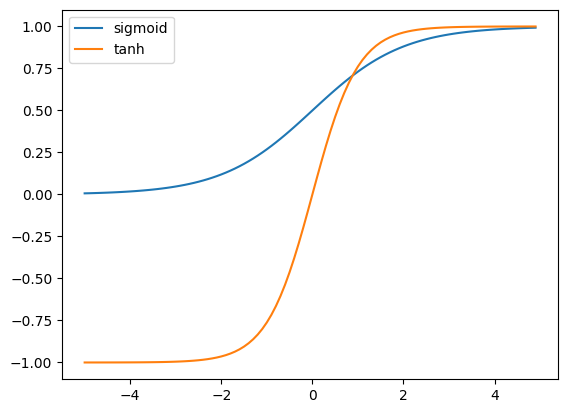

In [5]:
compare_activation_funcs(funcs=['sigmoid', 'tanh'], range=[-5,5])

$\mathrm{ReLu}(x) = \begin{cases}x, & x>0 \\ 0, & x\le 0 \end{cases}, \quad \mathrm{LeakyReLU}(x, k) = \begin{cases}x, & x>0 \\ kx, & x\le 0 \end{cases}, \quad\mathrm{SoftPlus}(x) = \ln(1+\exp(x)), \quad \mathrm{ELU}(x, \alpha) = \begin{cases} x, & x > 0 \\ \alpha \cdot (e^x - 1), & x \le 0  \end{cases}, \quad$

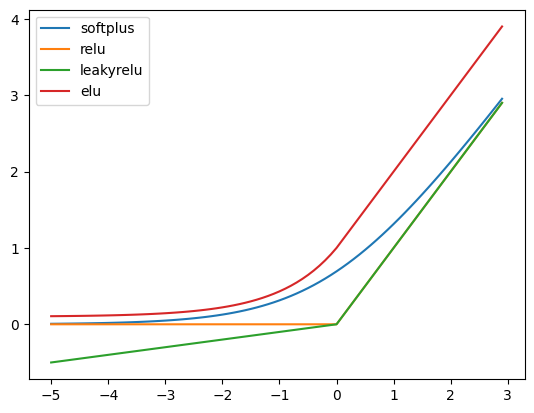

In [6]:
compare_activation_funcs(['relu', 'leakyrelu', 'softplus', 'elu'], range=[-5,3])

$\mathrm{GeLU}(x) = x\times\mathrm{CDF}_{\mathcal{N(0,1)}}(x) \approx \cfrac{1}{2}x\{1+\tanh[ \sqrt{\frac{2}{\pi}} \times (x + 0.044715x^3) ]\}, \quad \mathrm{SiLU}(x) = \cfrac{x}{1+\exp{(-x)}}$

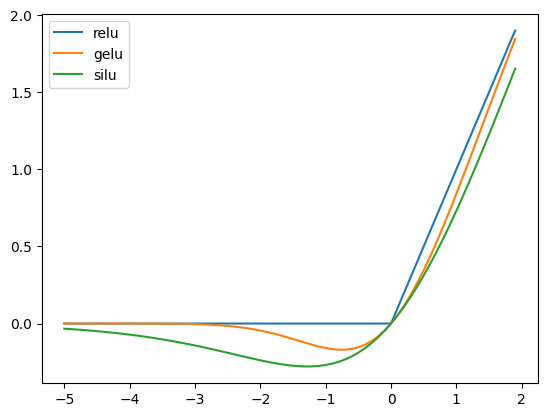

In [7]:
compare_activation_funcs(['relu', 'gelu', 'silu'], range=[-5,2])

##### step1-3. visualize the positional embeddings

In [8]:
def show_pe_img(pe: np.ndarray):
    """

    Args:
        pe (np.ndarray): shape: [max_seq_len, dim]
    """
    s = min(pe.shape)
    pe = np.resize(pe, (s,s))
    plt.imshow(pe)

In [9]:
def show_pe_curve(pe: np.ndarray):
    """

    Args:
        pe (np.ndarray): shape: [max_seq_len, dim]
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    position_ids = np.arange(20, pe.shape[1], 25)
    for idx in position_ids:
        ax.plot(range(pe.shape[0]), pe[:, idx], label=str(idx))
    ax.legend()
    plt.show()
    

##### step1-4. visualize causal mask

In [10]:
def show_01_causal_mask(m,n):
    mask = torch.tril(torch.ones(m,n))
    return mask


In [11]:
def show_bool_causal_mask(m,n):
    mask = torch.tril(torch.ones(m,n)).to(torch.bool)
    return mask


In [12]:
def show_0inf_causal_mask(m,n):
    mask = torch.tril(torch.ones(m,n)) - 1
    mask[mask<0] = -torch.inf
    return mask


In [13]:
show_01_causal_mask(1,4)

tensor([[1., 0., 0., 0.]])

In [14]:
show_bool_causal_mask(4,4)

tensor([[ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True]])

In [15]:
show_0inf_causal_mask(4,4)

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

##### step1-5. visualize the attention matrix

In [16]:
def show_attn_mat(mat: np.ndarray):
    plt.imshow(mat)


In [17]:
def show_attn_distribution(mat: np.ndarray):
    m, n = mat.shape
    x = np.linspace(0, n-1, 100)
    for i in range(m):
        xc, yc = range(n), mat[i]
        cs = CubicSpline(xc, yc)
        plt.plot(x, cs(x), label=str(i))
    plt.legend()
    plt.show()


##### step1-6. visualize the vocab probs

In [18]:
def show_vocab_probs(probs: np.ndarray):
    xc = np.linspace(0, len(probs)-1, 100).astype(np.int32)
    cs = CubicSpline(xc, probs[xc])
    x = np.linspace(0, len(probs)-1, 100000)
    plt.plot(xc, probs[xc], label='real')
    plt.plot(x, cs(x)+1e-4, alpha=0.6, label='smooth+1e-4')
    
    plt.legend()
    plt.show()


#### step2. modeling the model network

##### step2-0. define the modeling configs

In [19]:
class MiniLlamaConfig(PretrainedConfig):
    def __init__(self, 
            hidden_size=128,
            ffn_size=256,
            dropout_p=0.1,
            num_heads=4, # head_dim = 128 / 4 = 32
            vocab_size=10000,
            max_seq_len=1000,
            num_layers=3,
            device='cuda',
            **kwargs
        ):
        self.hidden_size = hidden_size
        self.ffn_size = ffn_size
        self.dropout_p = dropout_p
        self.num_heads = num_heads
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.num_layers = num_layers
        self.device = device
        
        super().__init__(**kwargs)
model_config = MiniLlamaConfig()
model_config

MiniLlamaConfig {
  "device": "cuda",
  "dropout_p": 0.1,
  "ffn_size": 256,
  "hidden_size": 128,
  "max_seq_len": 1000,
  "num_heads": 4,
  "num_layers": 3,
  "transformers_version": "4.31.0",
  "vocab_size": 10000
}

##### step2-1. modeling the RMSNorm

$\text{RMSNorm}(X) = W \odot \cfrac{X}{\mathrm{rms}(X)}, \quad\mathrm{rms}(X) = \sqrt{var(X) + \epsilon}, \quad var(X) = \cfrac{\sum\limits_{i=1}^n X_i^2}{n}$

In [20]:
class RMSNorm(nn.Module):
    def __init__(self, config: MiniLlamaConfig, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(config.hidden_size)).to(config.device)
        self.rms_eps = eps
        
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        """
        Args:
            hidden_states (torch.Tensor): shape: [batch_size, seq_len, hidden_size]

        Returns:
            torch.Tensor: shape: [batch_size, seq_len, hidden_size]
        """
        # pull up the precision
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        
        # rms normalization
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        rms = torch.rsqrt(variance + self.rms_eps)
        hidden_states = hidden_states * rms
        
        # learnable weight
        hidden_states = hidden_states * self.weight
        
        # push back the precision
        hidden_states = hidden_states.to(input_dtype)
        
        return hidden_states, rms
    
rms_norm = RMSNorm(model_config)

In [21]:
x = torch.rand(1, 1, model_config.hidden_size).to(model_config.device)
x[0, 0, :10], x.shape, rms_norm(x)[0][0, 0, :10], rms_norm(x)[0].shape, rms_norm(x)[1].item()

(tensor([0.3713, 0.4555, 0.3874, 0.9750, 0.8683, 0.3690, 0.9062, 0.3488, 0.7562,
         0.2386], device='cuda:0'),
 torch.Size([1, 1, 128]),
 tensor([0.6136, 0.7528, 0.6403, 1.6114, 1.4350, 0.6099, 1.4977, 0.5765, 1.2498,
         0.3943], device='cuda:0', grad_fn=<SliceBackward0>),
 torch.Size([1, 1, 128]),
 1.6527515649795532)

##### step2-2. modeling the FFN

$FFN(X) = \mathrm{down}[\mathrm{act}_{dropout}(\mathrm{up}(X))], \quad \mathrm{up}: \mathbb{R}^{d_{model}}\rightarrow \mathbb{R}^{d_{ffn}}, \mathrm{down}: \mathbb{R}^{d_{ffn}}\rightarrow \mathbb{R}^{d_{model}}$

In [22]:
class FFN(nn.Module):
    def __init__(self, config: MiniLlamaConfig) -> None:
        super().__init__()
        
        self.hidden_size = config.hidden_size
        self.ffn_size = config.ffn_size
        self.dropout_p = config.dropout_p
        
        self.up_proj = nn.Linear(self.hidden_size, self.ffn_size).to(config.device)
        self.down_proj = nn.Linear(self.ffn_size, self.hidden_size).to(config.device)
        
        # self.activation_func = F.relu
        # self.activation_func = F.elu
        self.activation_func = F.gelu
        self.dropout = nn.Dropout(p=self.dropout_p)
        
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        """

        Args:
            hidden_states (torch.Tensor): shape: [batch_size, seq_len, hidden_size]

        Returns:
            torch.Tensor: shape: [batch_size, seq_len, hidden_size]
        """
        hidden_states = self.up_proj(hidden_states) # [batch_size, seq_len, ffn_size]
        hidden_states = self.activation_func(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.down_proj(hidden_states) # [batch_size, seq_len, hidden_size]
        
        return hidden_states
        
ffn = FFN(model_config)
ffn

FFN(
  (up_proj): Linear(in_features=128, out_features=256, bias=True)
  (down_proj): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [23]:
x = torch.rand(3, 4, model_config.hidden_size).to(model_config.device)
x[0, 0, :10], x.shape, ffn(x)[0, 0, :10], ffn(x).shape

(tensor([0.3211, 0.4404, 0.0374, 0.0984, 0.7987, 0.0157, 0.9010, 0.6191, 0.0920,
         0.2989], device='cuda:0'),
 torch.Size([3, 4, 128]),
 tensor([-0.0815,  0.1022, -0.2091, -0.0452,  0.1013,  0.0004, -0.1410, -0.0353,
          0.0422,  0.0337], device='cuda:0', grad_fn=<SliceBackward0>),
 torch.Size([3, 4, 128]))

##### step2-3. modeling the Sinusodial Positional Encoding

$Sinusodial\;\; PE(n) := 
        \left[\begin{matrix}
            sin(n\theta^0) \\
            cos(n\theta^0) \\
            sin(n\theta^1) \\
            cos(n\theta^1) \\
            ...\\
            sin(n\theta^{\frac{d}{2}})\\
            cos(n\theta^{\frac{d}{2}})\\
        \end{matrix}\right], \quad \theta = base^{-\frac{2}{d}}, \quad base=10000$

In [24]:
class SinusodialPE(nn.Module):
    def __init__(self, config: MiniLlamaConfig, base=10000) -> None:
        super().__init__()
        
        self.dim = config.hidden_size
        self.max_seq_len = config.max_seq_len
        self.base = base
        
        self.pe = torch.zeros(self.max_seq_len, self.dim).to(config.device) # shape = [max_seq_len, dim]
        
        pos = torch.arange(0, self.max_seq_len, dtype=torch.float).to(config.device) # shape = [max_seq_len,]
        theta = 1 / self.base ** (torch.arange(0, self.dim, 2).float().to(config.device) / self.dim) # shape = [dim//2,]
        
        half_pe = torch.outer(pos, theta) # shape = [max_seq_len, dim//2]
        self.pe[:, 0::2] = torch.sin(half_pe)
        self.pe[:, 1::2] = torch.cos(half_pe)
        
    def forward(self, position_ids):
        return self.pe[position_ids]

sinpe = SinusodialPE(model_config)
sinpe.pe.shape

torch.Size([1000, 128])

In [25]:
position_ids = [0, 50, 99]
sinpe(position_ids)[:, :5]

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [-0.2624,  0.9650, -0.6320,  0.7750, -0.2030],
        [-0.9992,  0.0398, -0.7879, -0.6157, -0.9163]], device='cuda:0')

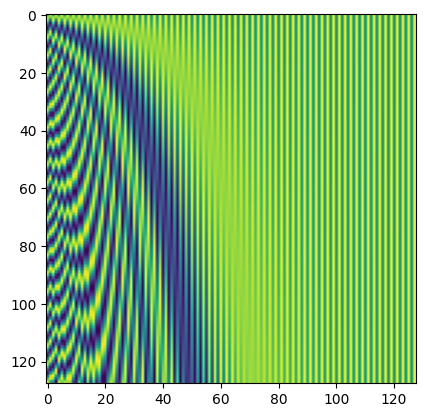

In [26]:
show_pe_img(sinpe.pe.detach().cpu().numpy())

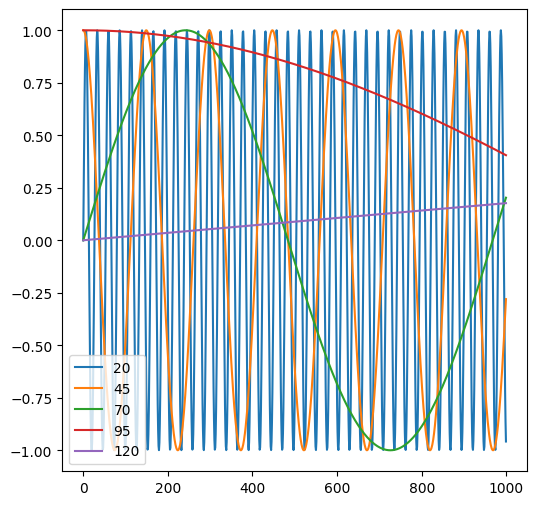

In [27]:
show_pe_curve(sinpe.pe.detach().cpu().numpy())

##### step2-4. modeling the Multi-Head Scaled Dot-Product Self-Attention 

$Q = X\times W_q, \quad K = X \times W_k,  \quad V = X\times W_v \\ P = Q \times K^T, \quad A = \mathrm{softmax}(\cfrac{P}{\sqrt{d_k}} \odot M), \quad O = (A \times V) \times W_o \\ \mathrm{softmax}(X) = \left[\cfrac{\exp(X_i - \max\limits_{i}(X_i))}{\sum\limits_{i=1}^N \exp(X_i - \max\limits_{i}(X_i))}\right]_{i=1}^N$

In [28]:
class Attention(nn.Module):
    def __init__(self, config: MiniLlamaConfig) -> None:
        super().__init__()
        
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_heads
        self.head_dim = self.hidden_size // self.num_heads
        
        self.qkv_proj = nn.Linear(self.hidden_size, 3*self.hidden_size).to(config.device) # shape = [hidden_size, 3*hidden_size]
        self.o_proj = nn.Linear(self.hidden_size, self.hidden_size).to(config.device) # shape = [hidden_size, hidden_size]
     
    @staticmethod   
    def _make_causal_mask(q_len, kv_len, device) -> torch.Tensor:
        mask = torch.tril(torch.ones(q_len, kv_len)).to(device) - 1
        mask[mask<0] = -torch.inf
        mask = mask.expand(1, 1, q_len, kv_len)
        return mask
        
    def forward(self, 
                hidden_states: torch.Tensor,
                past_kv_cache: Optional[Tuple[torch.Tensor]] = None,
                use_cache: bool = False,
                causal: bool = False,
                ) -> Tuple[torch.Tensor, torch.Tensor, Optional[Tuple[torch.Tensor]]]:
        """attention forward

        Args:
            hidden_states (torch.Tensor): shape = [batch_size, q_len, hidden_size]
            past_kv_cache (torch.Tensor, torch.Tensor): shape = [batch_size, num_heads, past_kv_len, head_dim], Defaults to None.
            use_cache (bool): whether to use kv cache, Defaults to False.
            causal (bool): whether to use causal mask, Defaults to False.
        Returns:
            O (torch.Tensor): shape = [batch_size, q_len, hidden_size]
            A (torch.Tensor): shape = [batch_size, q_len, kv_len]
            past_kv_cache (Optional[Tuple[torch.Tensor]]): shape = [batch_size, num_heads, past_kv_len, head_dim]
        """
        bs, q_len, _ = hidden_states.shape
        
        # QKV projection
        QKV = self.qkv_proj(hidden_states) # shape = [batch_size, q_len, 3*hidden_size]
        Q, K, V = QKV.chunk(3, dim=-1) # 3 * shape = [batch_size, q_len, hidden_size]
        
        # reshape Q, K, V for multi-head attention
        Q, K, V = [ # 3 * shape = [batch_size, num_heads, q_len, head_dim]
            x.view(bs, q_len, self.num_heads, self.head_dim).transpose(1,2)
            for x in [Q, K, V]
        ]
        
        # extend kv len with cache
        kv_len = K.shape[-2]
        if past_kv_cache is not None:
            kv_len += past_kv_cache[0].shape[-2]
            K = torch.concat([past_kv_cache[0], K], dim=-2)
            V = torch.concat([past_kv_cache[1], V], dim=-2)
        
        
        # update kv cache
        past_kv_cache = (K, V) if use_cache else None
        
        # P = Q x K^T
        P = Q @ K.transpose(-2, -1) # shape = [batch_size, num_heads, seq_len, seq_len]
        
        # prepapre attention mask
        if causal: mask = Attention._make_causal_mask(q_len, kv_len, Q.device)
        else: mask = 0.
        
        # A = softmax(P / √dk + M)
        mP = P.max(dim=-1, keepdim=True)[0]
        A = F.softmax((P-mP) / math.sqrt(self.head_dim) + mask, dim=-1) # shape = [batch_size, num_heads, q_len, kv_len]
        
        # O = A x V
        O = A @ V # shape = [batch_size, num_heads, q_len, head_dim]
        
        # reshape O back (NOTE: transpose may change the memory positions)
        O = O.transpose(1,2).contiguous().view(bs, q_len, -1) # shape = [batch_size, q_len, hidden_size]
        
        # O projection
        O = self.o_proj(O) # shape = [batch_size, q_len, hidden_size] 
        
        return O, A, past_kv_cache
    
attn = Attention(model_config)
attn

Attention(
  (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
  (o_proj): Linear(in_features=128, out_features=128, bias=True)
)

In [29]:
X = torch.rand(3, 10, model_config.hidden_size).to(model_config.device)
O, A, cache = attn(X, use_cache=True)
X.shape, O.shape, A.shape, cache[0].shape, cache[1].shape

(torch.Size([3, 10, 128]),
 torch.Size([3, 10, 128]),
 torch.Size([3, 4, 10, 10]),
 torch.Size([3, 4, 10, 32]),
 torch.Size([3, 4, 10, 32]))

(tensor([[0.0977, 0.1024, 0.1021, 0.1059, 0.0935, 0.0975, 0.1079, 0.1015, 0.0944,
          0.0971],
         [0.0904, 0.1065, 0.1021, 0.1043, 0.0928, 0.0980, 0.1064, 0.0980, 0.1000,
          0.1015],
         [0.0893, 0.1024, 0.1086, 0.0996, 0.0885, 0.1042, 0.1165, 0.0986, 0.0931,
          0.0993],
         [0.0923, 0.0967, 0.1029, 0.1009, 0.0905, 0.1009, 0.1186, 0.0982, 0.0973,
          0.1016],
         [0.0940, 0.0996, 0.1044, 0.0989, 0.0907, 0.0973, 0.1127, 0.1019, 0.0988,
          0.1018],
         [0.0917, 0.1020, 0.1060, 0.0976, 0.0924, 0.0980, 0.1164, 0.0978, 0.0983,
          0.0997],
         [0.0951, 0.1000, 0.1067, 0.0930, 0.0903, 0.0999, 0.1196, 0.1007, 0.0966,
          0.0981],
         [0.0929, 0.0995, 0.1041, 0.1033, 0.0899, 0.1047, 0.1104, 0.0993, 0.0958,
          0.1001],
         [0.0904, 0.0979, 0.1082, 0.1042, 0.0929, 0.0997, 0.1140, 0.0940, 0.0978,
          0.1009],
         [0.0925, 0.0999, 0.1030, 0.1014, 0.0918, 0.1025, 0.1097, 0.0995, 0.0967,
         

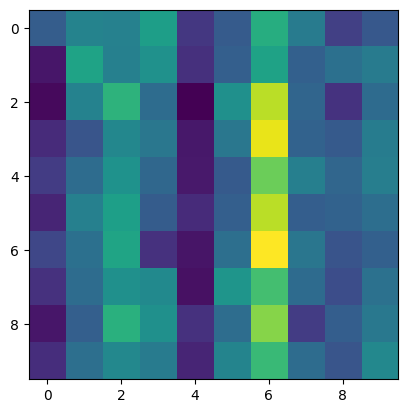

In [30]:
show_attn_mat(A[0,0].detach().cpu().numpy())
A[0,0], torch.sum(A[0,0], dim=-1)

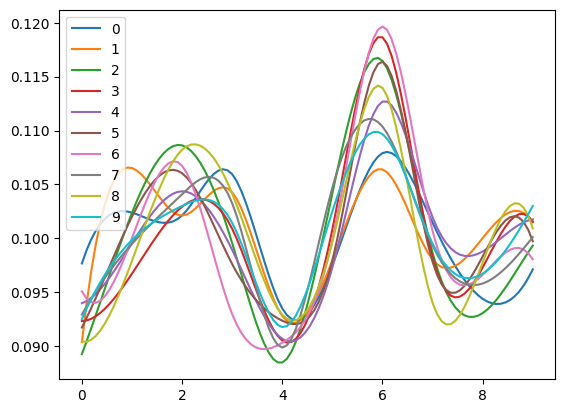

In [31]:
show_attn_distribution(A[0,0].detach().cpu().numpy())

In [32]:
Xnew = torch.rand(3, 1, model_config.hidden_size).to(model_config.device)
O, A, cache = attn(Xnew, use_cache=True, past_kv_cache=cache)
Xnew.shape, O.shape, A.shape, cache[0].shape, cache[1].shape

(torch.Size([3, 1, 128]),
 torch.Size([3, 1, 128]),
 torch.Size([3, 4, 1, 11]),
 torch.Size([3, 4, 11, 32]),
 torch.Size([3, 4, 11, 32]))

(tensor([[0.0856, 0.0929, 0.0953, 0.0858, 0.0841, 0.0925, 0.1036, 0.0879, 0.0874,
          0.0902, 0.0948]], device='cuda:0', grad_fn=<SelectBackward0>),
 tensor([1.], device='cuda:0', grad_fn=<SumBackward1>))

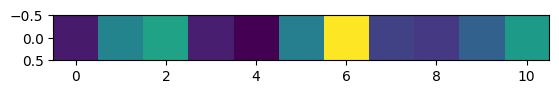

In [33]:
show_attn_mat(A[0,0].detach().cpu().numpy())
A[0,0], torch.sum(A[0,0], dim=-1)

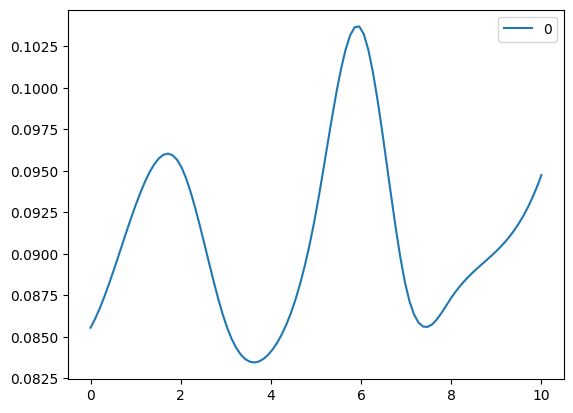

In [34]:
show_attn_distribution(A[0,0].detach().cpu().numpy())

In [35]:
X = torch.rand(3, 10, model_config.hidden_size).to(model_config.device)
O, A, cache = attn(X, use_cache=True, causal=True)
X.shape, O.shape, A.shape, cache[0].shape, cache[1].shape

(torch.Size([3, 10, 128]),
 torch.Size([3, 10, 128]),
 torch.Size([3, 4, 10, 10]),
 torch.Size([3, 4, 10, 32]),
 torch.Size([3, 4, 10, 32]))

(tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.5211, 0.4789, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.3337, 0.2967, 0.3696, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.2437, 0.2457, 0.2702, 0.2404, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.2012, 0.1852, 0.2203, 0.1912, 0.2021, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.1667, 0.1544, 0.1817, 0.1653, 0.1634, 0.1685, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.1489, 0.1333, 0.1604, 0.1316, 0.1417, 0.1410, 0.1432, 0.0000, 0.0000,
          0.0000],
         [0.1267, 0.1188, 0.1393, 0.1229, 0.1219, 0.1232, 0.1278, 0.1193, 0.0000,
          0.0000],
         [0.1130, 0.1002, 0.1235, 0.0977, 0.1078, 0.1077, 0.1149, 0.1144, 0.1209,
          0.0000],
         [0.1006, 0.0925, 0.1076, 0.0978, 0.1017, 0.0974, 0.1008, 0.0990, 0.1053,
         

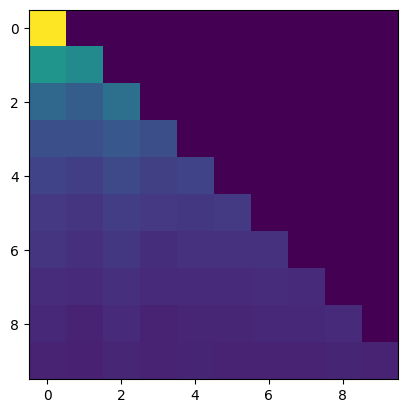

In [36]:
show_attn_mat(A[0,0].detach().cpu().numpy())
A[0,0], torch.sum(A[0,0], dim=-1)

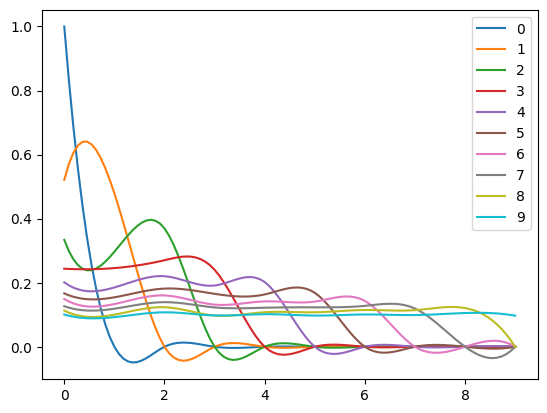

In [37]:
show_attn_distribution(A[0,0].detach().cpu().numpy())

##### step2-5. modeling the decoder block

In [38]:
class DecoderBlock(nn.Module):
    def __init__(self, model_config) -> None:
        super().__init__()
        
        self.hidden_size = model_config.hidden_size
        self.attn = Attention(model_config)
        self.ffn = FFN(model_config)
        self.norm = RMSNorm(model_config)
        
    def forward(self, 
                hidden_states: torch.Tensor,
                past_kv_cache: Optional[Tuple[torch.Tensor]] = None,
                use_cache: bool = False,
                causal: bool = False,
                )  -> Tuple[torch.Tensor, Optional[Tuple[torch.Tensor]]]:
        """decoder block forward

        Args:
            hidden_states (torch.Tensor): shape: [batch_size, q_len, hidden_size]
            past_kv_cache (Optional[Tuple[torch.Tensor]]): the kv cache. Defaults to None.
            use_cache (bool): whether to use kv cache. Defaults to False.
            causal (bool): whether to apply causal mask. Defaults to False.
        Returns:
            Tuple[torch.Tensor, torch.Tensor, Optional[torch.Tensor]]: output_hidden_states, attention_scores, past_kv_cache
        """
        # keep residual
        residual = hidden_states
        
        # self attention
        hidden_states, _, past_kv_cache = self.attn(
            hidden_states=hidden_states,
            use_cache=use_cache,
            past_kv_cache=past_kv_cache,
            causal=causal,
        )
        
        # attention output residual connection and normalization
        hidden_states = residual + self.norm(hidden_states)[0]
        
        # ffn
        residual = hidden_states
        hidden_states = self.ffn(hidden_states)
        
        # ffn output residual connection and normalization
        hidden_states = residual + self.norm(hidden_states)[0]
        
        return hidden_states, past_kv_cache
        
block1, block2 = DecoderBlock(model_config), DecoderBlock(model_config)
block1

DecoderBlock(
  (attn): Attention(
    (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
    (o_proj): Linear(in_features=128, out_features=128, bias=True)
  )
  (ffn): FFN(
    (up_proj): Linear(in_features=128, out_features=256, bias=True)
    (down_proj): Linear(in_features=256, out_features=128, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (norm): RMSNorm()
)

In [39]:
X = torch.rand(3, 10, model_config.hidden_size).to(model_config.device)
O1, cache1 = block1(X, use_cache=True, causal=True)
X.shape, O1.shape, cache1[0].shape, cache1[1].shape

(torch.Size([3, 10, 128]),
 torch.Size([3, 10, 128]),
 torch.Size([3, 4, 10, 32]),
 torch.Size([3, 4, 10, 32]))

In [40]:
O2, cache2 = block2(O1, use_cache=True, causal=True)
O2.shape, cache2[0].shape, cache2[1].shape

(torch.Size([3, 10, 128]),
 torch.Size([3, 4, 10, 32]),
 torch.Size([3, 4, 10, 32]))

##### step2-6. modeling the pretrained model

In [41]:
class MiniLlamaPretrainedModel(nn.Module):
    def __init__(self, config: MiniLlamaConfig) -> None:
        super().__init__()
        
        self.vocab_size = config.vocab_size
        self.num_layers = config.num_layers
        
        self.input_embed = nn.Embedding(config.vocab_size, config.hidden_size).to(config.device)
        self.pos_embed = SinusodialPE(config)
        
        self.blocks = nn.ModuleList([
            DecoderBlock(config)
            for _ in range(self.num_layers)
        ])
        
        self.output_norm = RMSNorm(config)
        
    def forward(self,
                input_ids: torch.LongTensor,
                past_kv_caches: Optional[List[Tuple[torch.Tensor]]] = None,
                use_cache: bool = False,
                causal: bool = False,
                ) -> Tuple[torch.Tensor, torch.Tensor]:
        """MiniLlama Pretrained Model forward

        Args:
            input_ids (torch.LongTensor): shape: [batch_size, seq_len]
            past_kv_caches (Optional[List[Tuple[torch.Tensor]]]): kv caches for each block. Defaults to None.
            use_cache (bool, optional): whether to use kv cache. Defaults to False.
            causal (bool, optional): whether to apply causal mask. Defaults to False.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: final_output_hidden_states, new_past_kv_caches
        """
        bs, seq_len = input_ids.shape
        
        # input embedding
        input_embeds = self.input_embed(input_ids) # shape = [batch_size, seq_len, hidden_size]
        
        # positional embedding
        pos_embeds = self.pos_embed(torch.arange(seq_len)).unsqueeze(0) # shape = [1, seq_len, hidden_size]
        hidden_states = input_embeds + pos_embeds # shape = [batch_size, seq_len, hidden_size]
        
        # prepare past kv caches
        if past_kv_caches is None:
            past_kv_caches = [None for _ in range(self.num_layers)]
        
        # decoder blocks
        for i, block in enumerate(self.blocks):
            hidden_states, past_kv_caches[i] = block(
                hidden_states=hidden_states,
                past_kv_cache=past_kv_caches[i],
                use_cache=use_cache,
                causal=causal,
            )
            
        # final output normalization
        hidden_states, _ = self.output_norm(hidden_states)
        
        return hidden_states, past_kv_caches
    
pretrain_model = MiniLlamaPretrainedModel(model_config)
pretrain_model

MiniLlamaPretrainedModel(
  (input_embed): Embedding(10000, 128)
  (pos_embed): SinusodialPE()
  (blocks): ModuleList(
    (0-2): 3 x DecoderBlock(
      (attn): Attention(
        (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
        (o_proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (ffn): FFN(
        (up_proj): Linear(in_features=128, out_features=256, bias=True)
        (down_proj): Linear(in_features=256, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm): RMSNorm()
    )
  )
  (output_norm): RMSNorm()
)

In [42]:
input_ids = torch.randint(0, model_config.vocab_size, (3, 10)).long().to(model_config.device)
O, caches = pretrain_model(input_ids, use_cache=True, causal=True)
input_ids.shape, O.shape, len(caches), caches[0][0].shape, caches[0][1].shape

(torch.Size([3, 10]),
 torch.Size([3, 10, 128]),
 3,
 torch.Size([3, 4, 10, 32]),
 torch.Size([3, 4, 10, 32]))

In [43]:
new_input_ids = torch.randint(0, model_config.vocab_size, (3, 1)).long().to(model_config.device)
O, caches = pretrain_model(new_input_ids, past_kv_caches=caches,  use_cache=True, causal=False)
new_input_ids.shape, O.shape, len(caches), caches[0][0].shape, caches[0][1].shape

(torch.Size([3, 1]),
 torch.Size([3, 1, 128]),
 3,
 torch.Size([3, 4, 11, 32]),
 torch.Size([3, 4, 11, 32]))

##### step2-7. modeling the language model

In [44]:
class MiniLlamaLanguageModel(nn.Module):
    def __init__(self, config: MiniLlamaConfig) -> None:
        super().__init__()
        
        self.hidden_size = config.hidden_size
        self.vocab_size = config.vocab_size
        
        self.pretrained_model = MiniLlamaPretrainedModel(config)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False).to(config.device)
        
    def forward(self, 
                input_ids: torch.LongTensor,
                past_kv_caches: Optional[List[Tuple[torch.Tensor]]] = None,
                use_cache: bool = False,
                causal: bool = False,
                ) -> Tuple[torch.Tensor, Optional[List[Tuple[torch.Tensor]]]]:
        """MiniLlama Language Model forward

        Args:
            input_ids (torch.LongTensor): shape: [batch_size, seq_len]
            past_kv_caches (Optional[List[Tuple[torch.Tensor]]]): kv caches for each block. Defaults to None.
            use_cache (bool, optional): whether to use kv cache. Defaults to False.
            causal (bool, optional): whether to apply causal mask. Defaults to False.
            use_softmax (bool, optional): whether to use softmax. Defaults to False.
        Returns:
            torch.LongTensor: the probability logits
            Optional[List[Tuple[torch.Tensor]]]: past_kv_caches
        """
        hidden_states, past_kv_caches = self.pretrained_model(input_ids, past_kv_caches, use_cache=use_cache, causal=causal) # shape = [batch_size, seq_len, hidden_size]
        logits = self.lm_head(hidden_states) # shape = [batch_size, seq_len, vocab_size]
        return logits, past_kv_caches
    
    def generate(self,
                input_ids: torch.LongTensor,
                max_new_tokens: int = 1,
                use_cache: bool = False,
                decoding_strategy: str = 'greedy',
                temperature: float = 1.0,
                ) -> torch.LongTensor:
        """generate token by token

        Args:
            input_ids (torch.LongTensor): shape: [batch_size, seq_len]
            max_new_tokens (int, optional): the max new tokens to generate. Defaults to 1.
            use_cache (bool, optional): whether to use kv cache. Defaults to False.
            decoding_strategy (str, optional): the decoding strategy. Defaults to 'greedy', you can choose 'sampling' too
            temperature (float, optional): the temperature of softmax. Defaults to 0.01.

        Returns:
            torch.LongTensor: output_ids, with shape: [batch_size, max_new_tokens]
        """
        output_ids = torch.zeros((input_ids.shape[0], max_new_tokens)).long()
        past_kv_caches = None
        
        for i in range(max_new_tokens):
            logits, past_kv_caches = self(input_ids, past_kv_caches, use_cache=use_cache, causal=i==0)
            probs = F.softmax(logits[:,-1,:] / temperature, dim=-1).squeeze(1) # shape = [batch_size, vocab_size]
            if decoding_strategy == 'greedy':
                next_tokens = torch.argmax(probs, dim=-1) # shape = [batch_size,]
            elif decoding_strategy == 'sampling':
                next_tokens = torch.multinomial(probs, num_samples=1).squeeze(1) # shape = [batch_size,]
            output_ids[:, i] = next_tokens
            input_ids = next_tokens.unsqueeze(1) # shape = [batch_size, 1], i.e. new_seq_len = 1
            
        return output_ids
    
    @staticmethod
    def softmax(logits: torch.Tensor, dim: int = -1, temperature: float = 1.0) -> torch.Tensor:
        max_logits = logits.max(dim=dim, keepdim=True)[0] # shape = [batch_size, seq_len, 1]
        logits -= max_logits
        probs = F.softmax(logits / temperature, dim=dim)
        return probs # shape = [batch_size, seq_len, vocab_size]
    
language_model = MiniLlamaLanguageModel(model_config)
language_model

MiniLlamaLanguageModel(
  (pretrained_model): MiniLlamaPretrainedModel(
    (input_embed): Embedding(10000, 128)
    (pos_embed): SinusodialPE()
    (blocks): ModuleList(
      (0-2): 3 x DecoderBlock(
        (attn): Attention(
          (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
          (o_proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (ffn): FFN(
          (up_proj): Linear(in_features=128, out_features=256, bias=True)
          (down_proj): Linear(in_features=256, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm): RMSNorm()
      )
    )
    (output_norm): RMSNorm()
  )
  (lm_head): Linear(in_features=128, out_features=10000, bias=False)
)

In [45]:
input_ids = torch.randint(0, model_config.vocab_size, (3, 10)).long().to(model_config.device)
logits, caches = language_model(input_ids, use_cache=True, causal=True)
input_ids.shape, logits.shape, len(caches), caches[0][0].shape, caches[0][1].shape

(torch.Size([3, 10]),
 torch.Size([3, 10, 10000]),
 3,
 torch.Size([3, 4, 10, 32]),
 torch.Size([3, 4, 10, 32]))

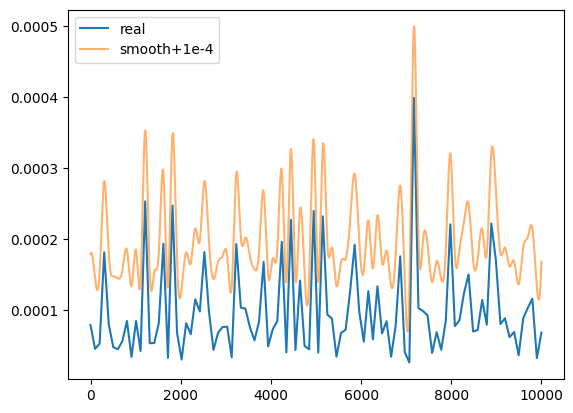

(torch.Size([3, 10, 10000]), None)

In [46]:
probs = language_model.softmax(logits, temperature=1.0)
probs.shape, show_vocab_probs(probs[0,-1].detach().cpu().numpy())

In [47]:
input_ids = torch.randint(0, model_config.vocab_size, (3, 10)).long().to(model_config.device)
output_ids_greedy = language_model.generate(input_ids, max_new_tokens=5, decoding_strategy='greedy', use_cache=True)
output_ids_sampling = language_model.generate(input_ids, max_new_tokens=5, decoding_strategy='sampling', use_cache=True)
input_ids.shape, output_ids_greedy.shape, output_ids_sampling.shape, output_ids_greedy, output_ids_sampling

(torch.Size([3, 10]),
 torch.Size([3, 5]),
 torch.Size([3, 5]),
 tensor([[4827, 1405, 1405, 1405, 1405],
         [ 787, 6128, 6014, 8843, 8599],
         [9015, 8599, 7723, 6190, 6128]]),
 tensor([[3623, 5577,  693, 4198, 9940],
         [4301, 2955, 7822, 8308, 8641],
         [1842, 1892, 5390, 6356, 3068]]))